In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv("/kaggle/input/elden-ring-steam-reviews/elden_ring_steam_reviews.csv")

print(f"Initial Shape: {df.shape}")


Initial Shape: (9794, 16)


In [3]:
df.head()


,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,134238864,english,being killed over and over again is fun,2023-03-07 14:19:11,True,0,0,False,False,False,47,2,355,355,346,2023-03-07 14:29:21
1,134238208,english,I write this review as I have 100% completed E...,2023-03-07 14:03:24,True,0,0,True,False,False,110,2,24238,5823,24238,2023-03-07 02:08:22
2,134238033,english,Fun,2023-03-07 13:59:13,True,0,0,True,False,False,11,1,912,912,881,2023-03-07 14:30:07
3,134237508,english,pretty cool.,2023-03-07 13:46:37,True,0,0,True,False,False,94,8,8497,2914,8497,2023-03-07 13:44:52
4,134236511,english,AMAZINGGGGGGGGGGGGG,2023-03-07 13:20:04,True,0,0,True,False,False,4,1,985,163,923,2023-03-07 14:26:41


In [4]:
df.dropna(inplace=True)
df['review'] = df['review'].astype(str)

In [5]:
# Removing urls from review
url_regex=re.compile('\b((https?|ftp|file):\/\/[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|])')

df["review"] = df["review"].apply(lambda x: url_regex.sub(r'', x))

In [6]:
# Removing emojis from review
emoji_regex = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

df["review"]= df['review'].apply(lambda x: emoji_regex.sub(r'', x))

In [7]:
print(f"After processing: {df.shape}")

After processing: (9765, 16)


In [8]:
# Just counting number of reviews with spoiler warning in them

reviews_with_spoilerwarning = df.review.str.count("spoiler").sum() + df.review.str.count("spoilers").sum()

print(reviews_with_spoilerwarning)

104


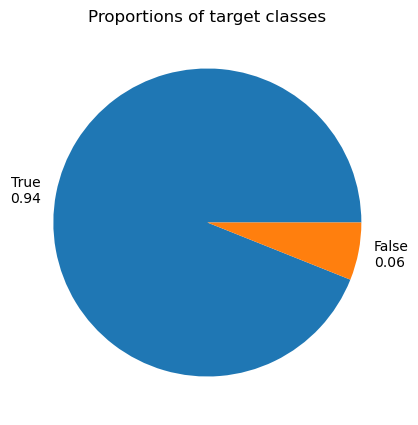

In [9]:
y= df.voted_up
X= df.drop(columns='voted_up')

target_balance =y.value_counts()

plt.figure(figsize = (5, 5))
plt.pie(target_balance, labels = [f'{idx}\n{round(target_balance[idx]/len(df), 2)}' for idx in target_balance.index])
plt.title('Proportions of target classes')
plt.show()

So we are dealing with class imbalance problem. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['voted_up'], test_size=0.7, random_state=42)

## Encoding prediction variable

In [11]:
Encoder = preprocessing.LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

## Vectorizing the data


In [12]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

## Creating a Linear SVM Model


In [13]:
import time
from sklearn import svm
from sklearn.metrics import classification_report

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear',degree=3)
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
target_names = ['Negative', 'Positive']
report = classification_report(y_test, prediction_linear,target_names=target_names,output_dict=True)
print('Positive: ', report['Positive'])
print('Negative: ', report['Negative'])


Training time: 0.217888s; Prediction time: 0.386663s
Positive:  {'precision': 0.9365753625311264, 'recall': 0.999218627910611, 'f1-score': 0.9668834114622712, 'support': 6399}
Negative:  {'precision': 0.4444444444444444, 'recall': 0.009153318077803204, 'f1-score': 0.017937219730941704, 'support': 437}


Now I am gonna try logsitic regression model. 

In [33]:
def train_cv(model, X_train, y_train, params, n_splits = 5, scoring = 'f1_weighted'):
    kf = KFold(n_splits = n_splits, random_state = 0, shuffle = True)

    cv = RandomizedSearchCV(model,
                        params,
                        cv=kf,
                        scoring=scoring,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=0,
                        random_state=1
                        )
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

rs_parameters = {
    'penalty': ['l2'],
    'C': uniform(scale=10),
    'solver': ['newton-cg', 'liblinear']
    }

In [34]:
lr = LogisticRegression()
model_cv_lr = train_cv(lr, train_vectors, y_train, rs_parameters)

bestimator_lr = model_cv_lr.best_estimator_

Best params {'C': 9.325573593386588, 'penalty': 'l2', 'solver': 'liblinear'}


In [35]:
print(classification_report(y_test, bestimator_lr.predict(test_vectors)))


              precision    recall  f1-score   support

           0       0.71      0.14      0.23       437
           1       0.94      1.00      0.97      6399

    accuracy                           0.94      6836
   macro avg       0.83      0.57      0.60      6836
weighted avg       0.93      0.94      0.92      6836



Better F1 score for 0 i.e. "Negative Reviews" class

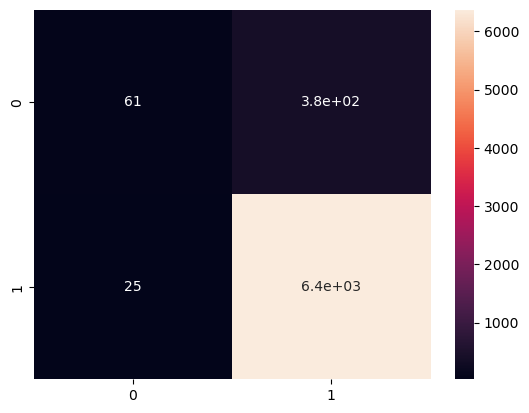

In [36]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(test_vectors)), annot=True)
plt.show()